# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image
import cv2

import torch
from torch.utils.data import Dataset

class CASIA_MS_Dataset(Dataset):
    def __init__(self, data_path):
        self.samples = []
        self.hand_id_map = {}
        self.domain_map = {}

        hand_id_counter = 0
        domain_counter = 0

        for root, _, files in os.walk(data_path):
            for fname in files:
                if not fname.lower().endswith(".jpg"):
                    continue

                # Expected format: ID_{l|r}_{spectrum}_{iteration}.jpg
                parts = fname[:-4].split("_")
                if len(parts) != 4:
                    continue

                subject_id, hand, spectrum, iteration = parts
                hand_id = f"{subject_id}_{hand}"

                if hand_id not in self.hand_id_map:
                    self.hand_id_map[hand_id] = hand_id_counter
                    hand_id_counter += 1

                if spectrum not in self.domain_map:
                    self.domain_map[spectrum] = domain_counter
                    domain_counter += 1

                img_path = os.path.join(root, fname)

                self.samples.append((
                    img_path,
                    self.hand_id_map[hand_id],     # y_i (identity label)
                    self.domain_map[spectrum]      # y_d (domain label)
                ))

        # 🔹 NEW: explicit domain-label list (for stratified splitting)
        self.domain_labels = [y_d for _, _, y_d in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, y_i, y_d = self.samples[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        # Resize
        img_np = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_LINEAR)

        img = torch.tensor(img_np, dtype=torch.float32).permute(2, 0, 1) / 255.0

        return img, y_i, y_d


# ================================
# Dataset
# ================================
data_path = "/content/drive/MyDrive/CASIA-MS-ROI"
dataset = CASIA_MS_Dataset(data_path)

num_classes = len(dataset.hand_id_map)
num_domains = len(dataset.domain_map)

print("Total samples:", len(dataset))
print("Hand ID classes:", num_classes)
print("Domains:", dataset.domain_map)




Total samples: 7243
Hand ID classes: 200
Domains: {'630': 0, 'WHT': 1, '460': 2, '850': 3, '700': 4, '940': 5}


**Registration and Query sets**

In [ ]:
from collections import defaultdict
import random
import numpy as np

# ================================
# Protocol parameters
# ================================
REG_RATIO = 0.75      # 50% for registration, 50% for query
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ================================
# Group samples by hand ID
# ================================
hand_to_indices = defaultdict(list)

for idx, (_, y_i, _) in enumerate(dataset.samples):
    hand_to_indices[y_i].append(idx)

all_hand_ids = list(hand_to_indices.keys())
num_total_hands = len(all_hand_ids)

print(f"Total hands: {num_total_hands}")
print(f"Total samples: {len(dataset.samples)}")

# ================================
# Split samples per hand (50/50)
# Registration and Query sets share the same hands
# ================================
reg_idx = []
qry_idx = []

for hid in all_hand_ids:
    indices = hand_to_indices[hid]
    random.shuffle(indices)
    split_point = int(len(indices) * REG_RATIO)

    reg_idx.extend(indices[:split_point])
    qry_idx.extend(indices[split_point:])

# ================================
# Sanity check
# ================================
def unique_hands(indices):
    return set(dataset.samples[i][1] for i in indices)

shared_hands = unique_hands(reg_idx).intersection(unique_hands(qry_idx))
print(f"Shared hands between registration and query: {len(shared_hands)} (expected: {num_total_hands})")

# ================================
# Final splits
# ================================
splits = {
    "open_reg": reg_idx,
    "open_query": qry_idx
}

for k, v in splits.items():
    print(f"{k:10s}: {len(v):5d} samples | {len(unique_hands(v))} hands")


Total hands: 200
Total samples: 7243
Shared hands between registration and query: 200 (expected: 200)
open_reg  :  5429 samples | 200 hands
open_query:  1814 samples | 200 hands


# Model Analysis

In [ ]:
pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=ada2fbe540a6bf069705ecaba01ff6b450c63c410ebaec71ba777df544192125
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=06a97c93b151be1ae6787f5aa1d1119af1d0889f736882f57243bc13076fd98e
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [ ]:
import torch
import timm
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# 1. Load the official DeiT-Small model
# deit_small_patch16_224 is the standard small variant
model_deit = timm.create_model('deit_tiny_patch16_224', pretrained=True)
model_deit.eval()

# 2. Create dummy input (DeiT natively uses 224x224)
dummy_input_deit = torch.randn(1, 3, 224, 224)

# 3. Analyze FLOPs (Inference Cost)
flops_deit = FlopCountAnalysis(model_deit, dummy_input_deit)
total_flops_deit = flops_deit.total()

# 4. Analyze Parameters
total_params_deit = sum(p.numel() for p in model_deit.parameters() if p.requires_grad)

print(f"--- DeiT-Small Analysis (224x224) ---")
print(f"Total Parameters: {total_params_deit / 1e6:.2f} Million")
print(f"Inference Cost:   {total_flops_deit / 1e9:.4f} GFLOPs")
#print("\nLayer-by-Layer Parameter Breakdown (Top Levels):")
#print(parameter_count_table(model_deit, max_depth=2))

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

blocks.0.attn.attn_drop, blocks.1.attn.attn_drop, blocks.10.attn.attn_drop, blocks.11.attn.attn_drop, blocks.2.attn.attn_drop, blocks.3.attn.attn_drop, blocks.4.attn.attn_drop, blocks.5.attn.attn_drop, blocks.6.attn.attn_drop, blocks.7.attn.attn_drop, blocks.8.attn.attn_drop, blocks.9.attn.attn_drop


--- DeiT-Small Analysis (224x224) ---
Total Parameters: 5.72 Million
Inference Cost:   1.0796 GFLOPs


In [ ]:
import torch
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load DINOv2 ViT-S/14
# ----------------------------
model_dino = torch.hub.load(
    "facebookresearch/dinov2",
    "dinov2_vits14"
).to(device)

model_dino.eval()

# ----------------------------
# Dummy input (224×224 RGB)
# ----------------------------
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# ----------------------------
# FLOPs analysis
# ----------------------------
flops = FlopCountAnalysis(model_dino, dummy_input)
total_flops = flops.total()

# ----------------------------
# Parameter count
# ----------------------------
total_params = sum(p.numel() for p in model_dino.parameters())

# ----------------------------
# Results
# ----------------------------
print("--- DINOv2 ViT-S/14 Analysis (224x224) ---")
print(f"Total Parameters: {total_params / 1e6:.2f} M")
print(f"Inference Cost:   {total_flops / 1e9:.4f} GFLOPs")

# Optional: layer-wise breakdown
# print(parameter_count_table(model_dino, max_depth=2))


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


--- DINOv2 ViT-S/14 Analysis (224x224) ---
Total Parameters: 22.06 M
Inference Cost:   5.5272 GFLOPs


# Main Loop

**Pretrained DeiT**

In [ ]:
# ============================================================
# Self-Supervised Contrastive Fine-tuning (SSL) – Single Cell
# Backbone: DeiT (no identity labels, NT-Xent loss)
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



'''
# 1. Load model from Torch Hub
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model.cuda().eval()

# 2. Prepare Transform (DINOv2 expects 224x224 and specific normalization)
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

'''
# ----------------------------
# Backbone (feature extractor)
# ----------------------------
backbone = timm.create_model(
    "deit_small_patch16_224",
    pretrained=True,
    num_classes=0
).to(device)

# Freeze most layers, unfreeze last (two) blocks
for name, p in backbone.named_parameters():
    p.requires_grad = False
    if "blocks.10" in name or "blocks.11" in name:
        p.requires_grad = True

# ----------------------------
# Projection Head (SSL only)
# ----------------------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, proj_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

proj_head = ProjectionHead(backbone.num_features, 128).to(device)

# ----------------------------
# NT-Xent (InfoNCE) Loss
# ----------------------------
def nt_xent_loss(z1, z2, temperature=0.1):
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)              # [2B, D]
    sim = torch.matmul(z, z.T) / temperature

    labels = torch.arange(B, device=z.device)
    labels = torch.cat([labels + B, labels])

    mask = torch.eye(2 * B, device=z.device).bool()
    sim.masked_fill_(mask, -1e9)

    return F.cross_entropy(sim, labels)

# ----------------------------
# SSL Augmentations
# ----------------------------
ssl_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor()
])

# ----------------------------
# Contrastive Dataset Wrapper
# base_dataset must return (img, y_i, y_d)
# ----------------------------
class ContrastiveDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _, _ = self.base_dataset[idx]  # ignore labels
        img = transforms.ToPILImage()(img)
        v1 = self.transform(img)
        v2 = self.transform(img)
        return v1, v2

# ----------------------------
# Dataset & Loader
# ----------------------------
# assumes: train_dataset already exists (CASIA subset for SSL)
ssl_dataset = ContrastiveDataset(dataset, ssl_transform) ################################ dataset

ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# ----------------------------
# Optimizer
# ----------------------------
optimizer = optim.AdamW(
    list(filter(lambda p: p.requires_grad, backbone.parameters())) +
    list(proj_head.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

# ----------------------------
# SSL Training Loop
# ----------------------------
epochs = 20
for epoch in range(epochs):
    backbone.train()
    proj_head.train()
    total_loss = 0.0

    for x1, x2 in tqdm(ssl_loader, desc=f"Epoch {epoch+1} [SSL]"):
        x1 = x1.to(device)
        x2 = x2.to(device)

        h1 = backbone(x1)
        h2 = backbone(x2)

        z1 = proj_head(h1)
        z2 = proj_head(h2)

        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | SSL Loss: {total_loss / len(ssl_loader):.4f}")

# ----------------------------
# IMPORTANT:
# After SSL, discard projection head.
# Use backbone embeddings for identification / verification.
# ----------------------------
backbone.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1 [SSL]:   0%|          | 0/113 [00:14<?, ?it/s]


KeyboardInterrupt: 

**Pretrained DinoV2**

In [ ]:
# ============================================================
# Self-Supervised Contrastive Fine-tuning (SSL) – Single Cell
# Backbone: DINOv2 ViT-S/14 (NT-Xent loss)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Backbone (DINOv2)
# ----------------------------
# Loading dinov2_vits14 (Small version, patch size 14)
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)

# DINOv2 Small embedding dimension is 384
# (For ViT-B use 768, ViT-L use 1024)
DINO_EMBED_DIM = 384

# Freeze most layers, unfreeze last (two) blocks
# In DINOv2 hub models, blocks are accessed via .blocks
for name, p in backbone.named_parameters():
    p.requires_grad = False
    # Unfreezing the last two blocks (block 10 and 11 for ViT-S)
    if "blocks.10" in name or "blocks.11" in name:
        p.requires_grad = True

# ----------------------------
# Projection Head (SSL only)
# ----------------------------
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, proj_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

# Using the explicit dimension for DINOv2
proj_head = ProjectionHead(DINO_EMBED_DIM, 128).to(device)

# ----------------------------
# NT-Xent (InfoNCE) Loss
# ----------------------------
def nt_xent_loss(z1, z2, temperature=0.1):
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)               # [2B, D]
    sim = torch.matmul(z, z.T) / temperature

    labels = torch.arange(B, device=z.device)
    labels = torch.cat([labels + B, labels])

    mask = torch.eye(2 * B, device=z.device).bool()
    sim.masked_fill_(mask, -1e9)

    return F.cross_entropy(sim, labels)

# ----------------------------
# SSL Augmentations (Optimized for DINOv2)
# ----------------------------
ssl_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)), # Multiples of 14 preferred
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    # DINOv2 uses standard ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ----------------------------
# Contrastive Dataset Wrapper
# ----------------------------
class ContrastiveDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Adjusted to handle common dataset returns (img, label)
        # or (img, label, other)
        data = self.base_dataset[idx]
        img = data[0]

        if not isinstance(img, Image.Image):
            img = transforms.ToPILImage()(img)

        v1 = self.transform(img)
        v2 = self.transform(img)
        return v1, v2

# ----------------------------
# Dataset & Loader
# ----------------------------
# Reusing your 'dataset' variable
ssl_dataset = ContrastiveDataset(dataset, ssl_transform)

ssl_loader = DataLoader(
    ssl_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# ----------------------------
# Optimizer
# ----------------------------
# Only optimize parameters with requires_grad=True
optimizer = optim.AdamW(
    list(filter(lambda p: p.requires_grad, backbone.parameters())) +
    list(proj_head.parameters()),
    lr=1e-5, # DINOv2 is sensitive; start with a lower LR than DeiT
    weight_decay=1e-4
)

# ----------------------------
# SSL Training Loop
# ----------------------------
epochs = 20
for epoch in range(epochs):
    backbone.train()
    proj_head.train()
    total_loss = 0.0

    for x1, x2 in tqdm(ssl_loader, desc=f"Epoch {epoch+1} [DINOv2 SSL]"):
        x1, x2 = x1.to(device), x2.to(device)

        # DINOv2 hub model returns the CLS token features [Batch, 384]
        h1 = backbone(x1)
        h2 = backbone(x2)

        z1 = proj_head(h1)
        z2 = proj_head(h2)

        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | SSL Loss: {total_loss / len(ssl_loader):.4f}")

backbone.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Epoch 1 [DINOv2 SSL]: 100%|██████████| 113/113 [03:21<00:00,  1.78s/it]


Epoch [1/20] | SSL Loss: 1.5692


Epoch 2 [DINOv2 SSL]: 100%|██████████| 113/113 [01:22<00:00,  1.36it/s]


Epoch [2/20] | SSL Loss: 0.8766


Epoch 3 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [3/20] | SSL Loss: 0.6735


Epoch 4 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [4/20] | SSL Loss: 0.5775


Epoch 5 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.35it/s]


Epoch [5/20] | SSL Loss: 0.5107


Epoch 6 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [6/20] | SSL Loss: 0.4638


Epoch 7 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [7/20] | SSL Loss: 0.4364


Epoch 8 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [8/20] | SSL Loss: 0.4066


Epoch 9 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [9/20] | SSL Loss: 0.3753


Epoch 10 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [10/20] | SSL Loss: 0.3632


Epoch 11 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [11/20] | SSL Loss: 0.3314


Epoch 12 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [12/20] | SSL Loss: 0.3198


Epoch 13 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [13/20] | SSL Loss: 0.3092


Epoch 14 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [14/20] | SSL Loss: 0.2967


Epoch 15 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [15/20] | SSL Loss: 0.2757


Epoch 16 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [16/20] | SSL Loss: 0.2694


Epoch 17 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [17/20] | SSL Loss: 0.2600


Epoch 18 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [18/20] | SSL Loss: 0.2463


Epoch 19 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]


Epoch [19/20] | SSL Loss: 0.2369


Epoch 20 [DINOv2 SSL]: 100%|██████████| 113/113 [01:23<00:00,  1.36it/s]

Epoch [20/20] | SSL Loss: 0.2370


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [ ]:
# ----------------------------
# Save the finetuned backbone
# ----------------------------
save_path = "/content/drive/MyDrive/CASIA-MS-ROI/smallDinoV2_CASIA_SSL_contrastive.pth"
torch.save(backbone.state_dict(), save_path)
print(f"Finetuned backbone saved at: {save_path}")

Finetuned backbone saved at: /content/drive/MyDrive/CASIA-MS-ROI/smallDinoV2_CASIA_SSL_contrastive.pth


# **Identification**

**Backbone Models**

In [ ]:
import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone_smalldeit = timm.create_model(
    "deit_small_patch16_224",
    pretrained=True,
    num_classes=0
).to(device)

backbone_tinydeit = timm.create_model(
    "deit_tiny_patch16_224",
    pretrained=True,
    num_classes=0
).to(device)

backbone_smalldino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 264MB/s]


**Fine-tuned Models with SSL**

In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### small Dino-V2
# Re-instantiate the base model architecture
# It must be the exact same model (dinov2_vits14)
finetuned_smalldino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# Load the saved weights
save_path = "/content/drive/MyDrive/CASIA-MS-ROI/smallDinoV2_CASIA_SSL_contrastive.pth"
state_dict = torch.load(save_path, map_location=device)
finetuned_smalldino.load_state_dict(state_dict)
finetuned_smalldino.to(device)
finetuned_smalldino.eval()
print("Finetuned DINOv2 loaded successfully.")


### tiny DeiT
finetuned_tinydeit = timm.create_model(
    "deit_tiny_patch16_224",
    pretrained=True,
    num_classes=0
).to(device)

save_path2 = "/content/drive/MyDrive/CASIA-MS-ROI/tinyDeiT_CASIA_SSL_contrastive.pth"
state_dict = torch.load(save_path2, map_location=device)
finetuned_tinydeit.load_state_dict(state_dict)
finetuned_tinydeit.to(device)
finetuned_tinydeit.eval()
print("finetuned_tinydeit loaded successfully.")



### small DeiT
finetuned_smalldeit = timm.create_model(
    "deit_small_patch16_224",
    pretrained=True,
    num_classes=0
).to(device)

save_path3 = "/content/drive/MyDrive/CASIA-MS-ROI/smallDeiT_CASIA_SSL_contrastive.pth"
state_dict = torch.load(save_path3, map_location=device)
finetuned_smalldeit.load_state_dict(state_dict)
finetuned_smalldeit.to(device)
finetuned_smalldeit.eval()
print("finetuned_smalldeit loaded successfully.")


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Finetuned DINOv2 loaded successfully.
finetuned_tinydeit loaded successfully.
finetuned_smalldeit loaded successfully.


**CASIA**

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from collections import defaultdict
from torchvision import transforms

@torch.no_grad()
def extract_embeddings(model, loader):
    feats = defaultdict(list)

    for imgs, labels, _ in loader:
        imgs = imgs.to(device)

        emb = model(imgs)          # (B, 192)
        emb = F.normalize(emb, dim=1)

        for e, l in zip(emb.cpu(), labels):
            feats[l].append(e)

    return feats


'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Crucial for DINOv2 feature extraction
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create Subsets using precomputed indices
reg_ds = Subset(dataset, reg_idx)
qry_ds = Subset(dataset, qry_idx)

# DataLoaders
reg_loader = DataLoader(
    reg_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

qry_loader = DataLoader(
    qry_ds,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("Registration samples:", len(reg_ds))
print("Query samples:", len(qry_ds))


# ========================================
# Extract embeddings (dictionary: label -> list of tensors)
# ========================================
reg_feats = extract_embeddings(backbone_tinydeit, reg_loader) ############################################# model/backbone
qry_feats = extract_embeddings(backbone_tinydeit, qry_loader)

# ========================================
# Flatten features: one row per sample (no averaging)
# ========================================
def flatten_feats(feat_dict):
    feat_list = []
    label_list = []
    for label, tensors in feat_dict.items():
        for t in tensors:
            feat_list.append(t)
            label_list.append(label)
    mat = torch.stack(feat_list)
    mat = F.normalize(mat, dim=1)
    return mat, label_list

RegMat, reg_labels = flatten_feats(reg_feats)
QryMat, qry_labels = flatten_feats(qry_feats)

print("Registration matrix:", RegMat.shape)  # e.g., (num_reg_samples, feat_dim)
print("Query matrix:", QryMat.shape)         # e.g., (num_query_samples, feat_dim)

# ========================================
# Cosine similarity: sample vs sample
# ========================================
sim = QryMat @ RegMat.T  # [num_query_samples, num_reg_samples]

# ========================================
# KNN (k = 5) classification
# ========================================

k = 1

# Top-k similarities and indices
topk_sim, topk_idx = torch.topk(sim, k=k, dim=1)  # [num_query, k]

pred_labels = []

for i in range(topk_idx.size(0)):
    neighbor_labels = [reg_labels[j] for j in topk_idx[i].tolist()]
    neighbor_sims   = topk_sim[i].tolist()

    # Majority vote
    label_votes = defaultdict(float)
    for lbl, s in zip(neighbor_labels, neighbor_sims):
        label_votes[lbl] += 1.0        # vote count
        # label_votes[lbl] += s        # (optional) similarity-weighted vote

    # Select label with highest vote
    pred_label = max(label_votes.items(), key=lambda x: x[1])[0]
    pred_labels.append(pred_label)



# ----------------------------
# Accuracy
# ----------------------------
accuracy = accuracy_score(qry_labels, pred_labels)
print(f"Sample-to-sample accuracy: {accuracy*100:.2f}%")


Registration samples: 5429
Query samples: 1814
Registration matrix: torch.Size([5429, 192])
Query matrix: torch.Size([1814, 192])
Sample-to-sample accuracy: 65.55%


**our data**

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class HandIDDataset(Dataset):
    def __init__(self, root_dir, sessions, transform=None):
        self.samples = []
        self.transform = transform

        participants = [f"{i:02d}" for i in range(1, 5)]
        hands = {"left": "l", "right": "r"}

        for pid in participants:
            for s in sessions:
                d = os.path.join(root_dir, f"{pid}_{s}")
                if not os.path.isdir(d):
                    continue

                for fname in os.listdir(d):
                    if not fname.lower().endswith(".jpg"):
                        continue

                    fname_lower = fname.lower()

                    # robust hand detection
                    hand_key = None
                    for h in hands:
                        if h in fname_lower:
                            hand_key = h
                            break

                    if hand_key is None:
                        continue  # skip files without left/right

                    label = f"{pid}_{hands[hand_key]}"
                    self.samples.append(
                        (os.path.join(d, fname), label)
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


Registration matrix: torch.Size([144, 384])
Query matrix: torch.Size([72, 384])
Sample-to-sample accuracy: 95.83%


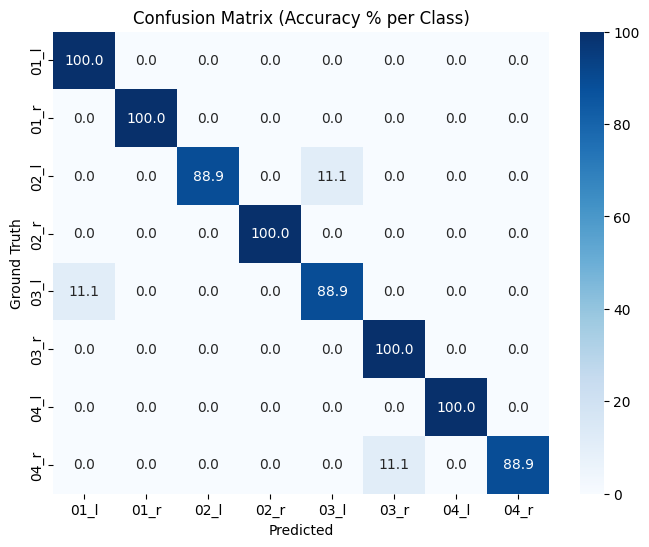

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from collections import defaultdict
from torchvision import transforms

##############################################################
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Converts to grayscale but keeps 3 channels (R=G=B)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Crucial for DINOv2 feature extraction
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

@torch.no_grad()
def extract_embeddings(model, loader):
    model.eval() # Ensure model is in eval mode
    feats = defaultdict(list)

    for imgs, labels in loader:
        imgs = imgs.to(device)

        # DINOv2 Small returns (B, 384)
        emb = model(imgs)
        emb = F.normalize(emb, dim=1)

        for e, l in zip(emb.cpu(), labels):
            feats[l].append(e)

    return feats

# ========================================
# Registration: S1 + S2
# ========================================
reg_ds = HandIDDataset(
    root_dir="/content/drive/MyDrive/palmprint_SIT/users-roi",
    sessions=["S3", "S1"],
    transform=transform
)

# Query: S3
qry_ds = HandIDDataset(
    root_dir="/content/drive/MyDrive/palmprint_SIT/users-roi",
    sessions=["S2"],
    transform=transform
)

reg_loader = DataLoader(reg_ds, batch_size=32, shuffle=False)
qry_loader = DataLoader(qry_ds, batch_size=32, shuffle=False)

# ========================================
# Extract embeddings (dictionary: label -> list of tensors)
# ========================================
reg_feats = extract_embeddings(finetuned_smalldino, reg_loader) #############################################
qry_feats = extract_embeddings(finetuned_smalldino, qry_loader)

# ========================================
# Flatten features: one row per sample (no averaging)
# ========================================
def flatten_feats(feat_dict):
    feat_list = []
    label_list = []
    for label, tensors in feat_dict.items():
        for t in tensors:
            feat_list.append(t)
            label_list.append(label)
    mat = torch.stack(feat_list)
    mat = F.normalize(mat, dim=1)
    return mat, label_list

RegMat, reg_labels = flatten_feats(reg_feats)
QryMat, qry_labels = flatten_feats(qry_feats)

print("Registration matrix:", RegMat.shape)  # e.g., (num_reg_samples, feat_dim)
print("Query matrix:", QryMat.shape)         # e.g., (num_query_samples, feat_dim)

# ========================================
# Cosine similarity: sample vs sample
# ========================================
sim = QryMat @ RegMat.T  # [num_query_samples, num_reg_samples]

# ========================================
# KNN classification
# ========================================

k = 1

# Top-k similarities and indices
topk_sim, topk_idx = torch.topk(sim, k=k, dim=1)  # [num_query, k]

pred_labels = []

for i in range(topk_idx.size(0)):
    neighbor_labels = [reg_labels[j] for j in topk_idx[i].tolist()]
    neighbor_sims   = topk_sim[i].tolist()

    # Majority vote
    label_votes = defaultdict(float)
    for lbl, s in zip(neighbor_labels, neighbor_sims):
        label_votes[lbl] += 1.0        # vote count
        # label_votes[lbl] += s        # (optional) similarity-weighted vote

    # Select label with highest vote
    pred_label = max(label_votes.items(), key=lambda x: x[1])[0]
    pred_labels.append(pred_label)


# ----------------------------
# Accuracy
# ----------------------------
accuracy = accuracy_score(qry_labels, pred_labels)
print(f"Sample-to-sample accuracy: {accuracy*100:.2f}%")


# ----------------------------
# Confusion matrix (Normalized %)
# ----------------------------
labels_sorted = sorted(list(set(qry_labels + reg_labels)))

# Use normalize='true' to get proportions (0 to 1) per row
cm = confusion_matrix(qry_labels, pred_labels, labels=labels_sorted, normalize='true')

# Convert proportions to percentages
cm_percent = cm * 100

# Plot
plt.figure(figsize=(8,6))
# fmt=".1f" displays one decimal point; adjust to ".2f" for two
sns.heatmap(cm_percent, annot=True, fmt=".1f", xticklabels=labels_sorted, yticklabels=labels_sorted, cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Accuracy % per Class)")
plt.show()


**cross-session identification**

In [ ]:
import pandas as pd

# List of models to evaluate
models_to_test = {
    "Backbone Tiny-DeiT": backbone_tinydeit,
    "Backbone Small-DeiT": backbone_smalldeit,
    "Backbone Small-Dino": backbone_smalldino,
    "Finetuned Tiny-DeiT": finetuned_tinydeit,
    "Finetuned Small-DeiT": finetuned_smalldeit,
    "Finetuned Small-Dino": finetuned_smalldino
}

# Session combinations: (Registration Sessions, Query Session)
session_splits = [
    (["S1", "S2"], ["S3"]),
    (["S1", "S3"], ["S2"]),
    (["S2", "S3"], ["S1"])
]

results = []

for model_name, model in models_to_test.items():
    model.to(device)
    model.eval()

    row = {"Model": model_name}

    for reg_sess, qry_sess in session_splits:
        split_name = f"Reg:{'+'.join(reg_sess)} / Qry:{qry_sess[0]}"

        # 1. Setup DataLoaders for this specific split
        reg_ds = HandIDDataset(root_dir="/content/drive/MyDrive/palmprint_SIT/users-roi",
                               sessions=reg_sess, transform=transform)
        qry_ds = HandIDDataset(root_dir="/content/drive/MyDrive/palmprint_SIT/users-roi",
                               sessions=qry_sess, transform=transform)

        reg_loader = DataLoader(reg_ds, batch_size=32, shuffle=False)
        qry_loader = DataLoader(qry_ds, batch_size=32, shuffle=False)

        # 2. Extract and Flatten features
        reg_feats = extract_embeddings(model, reg_loader)
        qry_feats = extract_embeddings(model, qry_loader)

        RegMat, reg_labels = flatten_feats(reg_feats)
        QryMat, qry_labels = flatten_feats(qry_feats)

        # 3. Compute Similarity and Preds (KNN k=1)
        # Move to GPU for faster matrix multiplication if possible
        RegMat, QryMat = RegMat.to(device), QryMat.to(device)
        sim = QryMat @ RegMat.T

        _, topk_idx = torch.topk(sim, k=1, dim=1)

        # 4. Calculate Accuracy
        pred_labels = [reg_labels[i.item()] for i in topk_idx.flatten()]
        acc = accuracy_score(qry_labels, pred_labels) * 100

        row[split_name] = f"{acc:.2f}%"

    results.append(row)

# ========================================
# Output Table
# ========================================
df = pd.DataFrame(results)
print(df.to_string(index=False))

# Optional: Save to CSV
# df.to_csv("model_evaluation_results.csv", index=False)

               Model Reg:S1+S2 / Qry:S3 Reg:S1+S3 / Qry:S2 Reg:S2+S3 / Qry:S1
  Backbone Tiny-DeiT             52.78%             65.28%             52.78%
 Backbone Small-DeiT             66.67%             68.06%             58.33%
 Backbone Small-Dino             66.67%             77.78%             54.17%
 Finetuned Tiny-DeiT             73.61%             75.00%             63.89%
Finetuned Small-DeiT             72.22%             84.72%             75.00%
Finetuned Small-Dino             90.28%             95.83%             80.56%


Leave-One-Spectrum-Out (LOSO) Evaluation

In [ ]:
class HandIDDataset(Dataset):
    def __init__(self, root_dir, sessions, target_spectrums=None, transform=None):
        self.samples = []
        self.transform = transform
        # Your specific 9 spectrums
        self.all_spectrums = ["red", "green", "blue", "white", "ir", "magenta", "yellow", "pink", "orange"]

        # Adjust range based on your current participant count (e.g., 1 to 4)
        participants = [f"{i:02d}" for i in range(1, 5)]
        hands = {"left": "l", "right": "r"}

        for pid in participants:
            for s in sessions:
                d = os.path.join(root_dir, f"{pid}_{s}")
                if not os.path.isdir(d): continue

                for fname in os.listdir(d):
                    if not fname.lower().endswith(".jpg"): continue

                    fname_lower = fname.lower()

                    # 1. Detect Spectrum from filename (e.g., 'blue' in '01_S1_Left_blue.jpg')
                    spec_found = None
                    for spec in self.all_spectrums:
                        if spec in fname_lower:
                            spec_found = spec
                            break

                    if spec_found is None: continue

                    # 2. Filter based on the target_spectrums list
                    if target_spectrums is not None and spec_found not in target_spectrums:
                        continue

                    # 3. Detect Hand (robust check for 'left' or 'right')
                    hand_key = None
                    for h in hands:
                        if h in fname_lower:
                            hand_key = h
                            break

                    if hand_key:
                        label = f"{pid}_{hands[hand_key]}"
                        self.samples.append((os.path.join(d, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label



import pandas as pd

# Define models to evaluate
models_dict = {
    "Backbone Tiny-DeiT": backbone_tinydeit,
    "Backbone Small-DeiT": backbone_smalldeit,
    "Backbone Small-Dino": backbone_smalldino,
    "Finetuned Tiny-DeiT": finetuned_tinydeit,
    "Finetuned Small-DeiT": finetuned_smalldeit,
    "Finetuned Small-Dino": finetuned_smalldino
}

target_spectrums = ["red", "green", "blue", "white", "ir", "magenta", "yellow", "pink", "orange"]
results = []

for name, model in models_dict.items():
    model.to(device)
    model.eval()
    model_results = {"Model": name}

    print(f"Evaluating {name}...")

    for qry_spec in target_spectrums:
        # Reg = {All 9 spectrums except current one}, Que = {Current spectrum}
        reg_specs = [s for s in target_spectrums if s != qry_spec]

        # Load datasets (using S1, S2, and S3 for maximum gallery coverage)
        reg_ds = HandIDDataset(root_dir="/content/drive/MyDrive/palmprint_SIT/users-roi",
                               sessions=["S1", "S2", "S3"], target_spectrums=reg_specs, transform=transform)
        qry_ds = HandIDDataset(root_dir="/content/drive/MyDrive/palmprint_SIT/users-roi",
                               sessions=["S1", "S2", "S3"], target_spectrums=[qry_spec], transform=transform)

        if len(reg_ds) == 0 or len(qry_ds) == 0:
            model_results[f"Que:{qry_spec}"] = "N/A"
            continue

        reg_loader = DataLoader(reg_ds, batch_size=32, shuffle=False)
        qry_loader = DataLoader(qry_ds, batch_size=32, shuffle=False)

        # Extract features
        reg_feats = extract_embeddings(model, reg_loader)
        qry_feats = extract_embeddings(model, qry_loader)

        RegMat, reg_labels = flatten_feats(reg_feats)
        QryMat, qry_labels = flatten_feats(qry_feats)

        # Similarity Matching
        sim = QryMat.to(device) @ RegMat.to(device).T
        topk_idx = torch.topk(sim, k=1, dim=1)[1]

        pred_labels = [reg_labels[idx.item()] for idx in topk_idx.flatten()]
        acc = accuracy_score(qry_labels, pred_labels) * 100

        model_results[f"Que:{qry_spec}"] = f"{acc:.1f}%"

    results.append(model_results)

# Create and display final comparison table
df_results = pd.DataFrame(results)
print("\n--- Cross-Spectral Evaluation Table ---")
print(df_results.to_string(index=False))

Evaluating Backbone Tiny-DeiT...
Evaluating Backbone Small-DeiT...
Evaluating Backbone Small-Dino...
Evaluating Finetuned Tiny-DeiT...
Evaluating Finetuned Small-DeiT...
Evaluating Finetuned Small-Dino...

--- Cross-Spectral Evaluation Table ---
               Model Que:red Que:green Que:blue Que:white Que:ir Que:magenta Que:yellow Que:pink Que:orange
  Backbone Tiny-DeiT   33.3%     58.3%    66.7%    100.0%  33.3%       79.2%      91.7%    83.3%      95.8%
 Backbone Small-DeiT   41.7%     58.3%    66.7%     91.7%  25.0%       70.8%     100.0%    95.8%     100.0%
 Backbone Small-Dino   83.3%     62.5%    62.5%    100.0%  25.0%       91.7%     100.0%    83.3%      95.8%
 Finetuned Tiny-DeiT   66.7%     66.7%    79.2%    100.0%  33.3%       87.5%     100.0%    87.5%      95.8%
Finetuned Small-DeiT   41.7%     79.2%    91.7%    100.0%  45.8%      100.0%     100.0%    95.8%     100.0%
Finetuned Small-Dino   70.8%     79.2%    66.7%    100.0%  37.5%       95.8%     100.0%    95.8%     100.0

# **Verification**

In [ ]:
# ============================================
# Palmprint Verification (EER) – CASIA-MS FULL
# ============================================

import os
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ----------------------------
# Paths & model
# ----------------------------
ROOT_DIR = "/content/drive/MyDrive/CASIA-MS-ROI"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone.eval()
backbone.to(device)

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ----------------------------
# Parse CASIA-MS images
# Label = subject_hand (e.g., 001_l)
# ----------------------------
images = []
labels = []

for root, _, files in os.walk(ROOT_DIR):
    for fname in files:
        if not fname.lower().endswith(".jpg"):
            continue

        # Expected: ID_{l|r}_{spectrum}_{iteration}.jpg
        parts = fname[:-4].split("_")
        if len(parts) != 4:
            continue

        subject_id, hand, spectrum, iteration = parts
        if hand not in ["l", "r"]:
            continue

        label = f"{subject_id}_{hand}"
        img_path = os.path.join(root, fname)

        images.append(img_path)
        labels.append(label)

print(f"Total images: {len(images)}")
print(f"Total unique hands: {len(set(labels))}")

assert len(images) > 0, "No images found — check dataset path or filename format"

# ----------------------------
# Extract embeddings
# ----------------------------
embeddings = []

with torch.no_grad():
    for img_path in images:
        img = Image.open(img_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)

        emb = backbone(img)          # [1, D] ################################################
        emb = F.normalize(emb, dim=1)

        embeddings.append(emb.cpu())

embeddings = torch.cat(embeddings, dim=0)  # [N, D]

# ----------------------------
# Genuine / Impostor matching
# ----------------------------
genuine_scores = []
impostor_scores = []

N = len(labels)

for i in range(N):
    for j in range(i + 1, N):
        sim = torch.dot(embeddings[i], embeddings[j]).item()

        if labels[i] == labels[j]:
            genuine_scores.append(sim)
        else:
            impostor_scores.append(sim)

print(f"Genuine pairs: {len(genuine_scores)}")
print(f"Impostor pairs: {len(impostor_scores)}")

# ----------------------------
# EER computation
# ----------------------------
scores = np.array(genuine_scores + impostor_scores)
y_true = np.array([1] * len(genuine_scores) + [0] * len(impostor_scores))

fpr, tpr, _ = roc_curve(y_true, scores)
fnr = 1 - tpr

eer_idx = np.argmin(np.abs(fpr - fnr))
eer = (fpr[eer_idx] + fnr[eer_idx]) / 2

print(f"\n Equal Error Rate (EER): {eer*100:.2f}%")

# ----------------------------
# Score distribution
# ----------------------------
plt.figure(figsize=(7,5))
plt.hist(genuine_scores, bins=50, alpha=0.6, label="Genuine")
plt.hist(impostor_scores, bins=50, alpha=0.6, label="Impostor")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("CASIA-MS Palmprint Verification Score Distribution")
plt.legend()
plt.show()


NameError: name 'backbone' is not defined

Total images: 216
Total unique hands: 8
Genuine pairs: 2808
Impostor pairs: 20412

 Equal Error Rate (EER): 46.72%


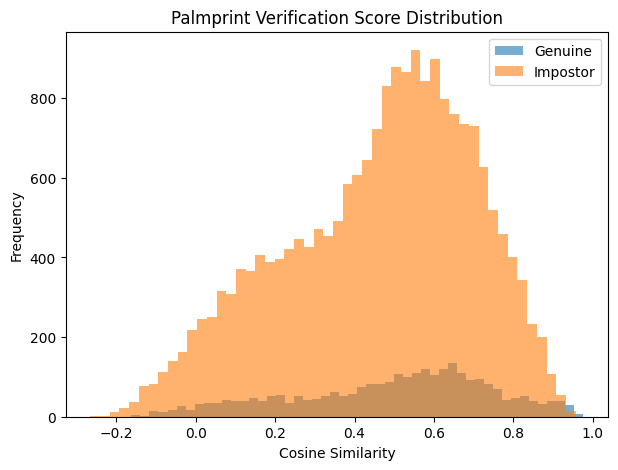

In [ ]:
# ============================================
# Palmprint Verification (EER) – CORRECT PARSER
# ============================================

import os
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ----------------------------
# Paths & model
# ----------------------------
ROOT_DIR = "/content/drive/MyDrive/palmprint_SIT/users-roi"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone.eval()
backbone.to(device)

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ----------------------------
# Load images and labels
# label = subject_hand (e.g., 03_l)
# ----------------------------
images = []
labels = []

for root, _, files in os.walk(ROOT_DIR):
    folder = os.path.basename(root)

    # Expect folder like: 03_S1
    if "_" not in folder:
        continue

    subject_id = folder.split("_")[0]

    for f in files:
        if not f.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        fname = f.lower()

        # ---- Hand from filename
        if "_left_" in fname:
            hand = "l"
        elif "_right_" in fname:
            hand = "r"
        else:
            continue  # skip malformed names

        img_path = os.path.join(root, f)
        label = f"{subject_id}_{hand}"

        images.append(img_path)
        labels.append(label)

print(f"Total images: {len(images)}")
print(f"Total unique hands: {len(set(labels))}")

assert len(images) > 0, "No images found — check filename format"

# ----------------------------
# Extract embeddings
# ----------------------------
embeddings = []

with torch.no_grad():
    for img_path in images:
        img = Image.open(img_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        emb = backbone(img) ###########################################################
        emb = F.normalize(emb, dim=1)
        embeddings.append(emb.cpu())

embeddings = torch.cat(embeddings, dim=0)  # [N, D]

# ----------------------------
# Genuine / Impostor matching
# ----------------------------
genuine_scores = []
impostor_scores = []

N = len(labels)

for i in range(N):
    for j in range(i + 1, N):
        sim = torch.dot(embeddings[i], embeddings[j]).item()
        if labels[i] == labels[j]:
            genuine_scores.append(sim)
        else:
            impostor_scores.append(sim)

print(f"Genuine pairs: {len(genuine_scores)}")
print(f"Impostor pairs: {len(impostor_scores)}")

# ----------------------------
# EER computation
# ----------------------------
scores = np.array(genuine_scores + impostor_scores)
y_true = np.array([1]*len(genuine_scores) + [0]*len(impostor_scores))

fpr, tpr, _ = roc_curve(y_true, scores)
fnr = 1 - tpr

eer_idx = np.argmin(np.abs(fpr - fnr))
eer = (fpr[eer_idx] + fnr[eer_idx]) / 2

print(f"\n Equal Error Rate (EER): {eer*100:.2f}%")

# ----------------------------
# Score distribution
# ----------------------------
plt.figure(figsize=(7,5))
plt.hist(genuine_scores, bins=50, alpha=0.6, label="Genuine")
plt.hist(impostor_scores, bins=50, alpha=0.6, label="Impostor")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Palmprint Verification Score Distribution")
plt.legend()
plt.show()


# **ROI Extraction**

In [ ]:
!pip install mediapipe==0.10.13

In [ ]:
# google_roi.py
"""
Hand-ROI extractor based on MediaPipe Hands (single hand, 21 landmarks).

Public API
----------
extract_palm_roi(image: numpy.ndarray) -> (roi_bgr, annotated_bgr, hand_type)

• roi_bgr          – cropped palm ROI (BGR)
• annotated_bgr    – same size as input with landmarks & box drawn
• hand_type        – "Left" / "Right" / "Unknown"
"""

import cv2
import numpy as np
import mediapipe as mp

# ----------------------------------------------------------------------
# Internal helpers
# ----------------------------------------------------------------------

def _run_mp_hands(image, min_det_conf=0.2):
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=min_det_conf
    ) as hands:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        if not res.multi_hand_landmarks:
            return None, None

        lm = res.multi_hand_landmarks[0]
        handedness = (
            res.multi_handedness[0].classification[0].label
            if res.multi_handedness else "Unknown"
        )

        h, w = image.shape[:2]
        pts = [(int(p.x * w), int(p.y * h)) for p in lm.landmark]
        return pts, handedness


def _midpoints(pairs):
    return [((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2) for p1, p2 in pairs]


def _calculate_point_c(m1, m2, thumb):
    m1, m2, thumb = map(np.asarray, (m1, m2, thumb))

    O = (m1 + m2) / 2.0
    AB = m2 - m1
    L = np.linalg.norm(AB)
    if L == 0:
        raise ValueError("Midpoints coincide")

    ABu = AB / L
    perp = np.array([-ABu[1], ABu[0]])

    # ---- NumPy 2.0–safe 2D cross product (scalar z-component)
    cross_z = ABu[0] * (thumb - O)[1] - ABu[1] * (thumb - O)[0]
    if cross_z < 0:
        perp = -perp

    C = O + 1.8 * L * perp
    return int(C[0]), int(C[1])  # ensure Python ints


def _extract_roi(img, mid1, mid2, C, thumb, hand_type):
    vec = np.array(mid2) - np.array(mid1)
    angle = np.degrees(np.arctan2(vec[1], vec[0]))

    C = (int(C[0]), int(C[1]))  # OpenCV-safe center

    if hand_type.lower() == "right":
        if np.dot(vec, np.array(thumb) - np.array(C)) > 0:
            angle += 180
    else:  # left / unknown
        if np.dot(vec, np.array(thumb) - np.array(C)) < 0:
            angle += 180

    side = np.linalg.norm(vec) * 2.5
    rect = (C, (side, side), angle)

    M = cv2.getRotationMatrix2D(C, angle, 1.0)
    rot = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    roi = cv2.getRectSubPix(rot, (int(side), int(side)), C)

    box = cv2.boxPoints(rect).astype(int)
    return roi, box

# ----------------------------------------------------------------------
# Public function
# ----------------------------------------------------------------------

def extract_palm_roi(image_bgr):
    """
    Parameters
    ----------
    image_bgr : np.ndarray
        BGR image.

    Returns
    -------
    roi_bgr, annotated_bgr, hand_type
        If landmarks fail → returns (None, None, None)
    """
    lms, hand_type = _run_mp_hands(image_bgr)
    if lms is None:
        return None, None, None

    idx = lambda i: lms[i]

    mids4 = _midpoints([
        (idx(17), idx(18)),
        (idx(14), idx(13)),
        (idx(10), idx(9)),
        (idx(6),  idx(5))
    ])

    adj = _midpoints([
        (mids4[0], mids4[1]),
        (mids4[1], mids4[2]),
        (mids4[2], mids4[3])
    ])

    roi_mid1 = ((adj[0][0] + adj[1][0]) / 2,
                (adj[0][1] + adj[1][1]) / 2)

    roi_mid2 = ((adj[1][0] + adj[2][0]) / 2,
                (adj[1][1] + adj[2][1]) / 2)

    thumb = idx(2)
    C = _calculate_point_c(roi_mid1, roi_mid2, thumb)

    roi, box = _extract_roi(image_bgr, roi_mid1, roi_mid2, C, thumb, hand_type)

    # Annotated image
    ann = image_bgr.copy()
    for x, y in lms:
        cv2.circle(ann, (x, y), 3, (0, 255, 0), -1)

    cv2.polylines(ann, [box], True, (0, 255, 0), 2)
    cv2.circle(ann, C, 6, (0, 0, 255), -1)

    return roi, ann, hand_type


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

# ================================
# Paths
# ================================
SRC_ROOT = "/content/drive/MyDrive/palmprint_SIT/users"
DST_ROOT = "/content/drive/MyDrive/palmprint_SIT/users-roi"

os.makedirs(DST_ROOT, exist_ok=True)


# ================================
# Collect all images
# ================================
all_images = []
for root, _, files in os.walk(SRC_ROOT):
    for f in files:
        if f.lower().endswith(".jpg"):
            all_images.append(os.path.join(root, f))

print(f"Total images found: {len(all_images)}")


# ================================
# Counters
# ================================
num_success = 0
num_failed = 0


# ================================
# Batch processing
# ================================
failed_images = []
for src_path in tqdm(all_images):
    rel_path = os.path.relpath(src_path, SRC_ROOT)
    dst_path = os.path.join(DST_ROOT, rel_path)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    # ---- Load image (RGB)
    img_rgb = np.array(Image.open(src_path).convert("RGB"))

    # ---- Convert to BGR for ROI extractor
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    # ---- Extract palm ROI (advanced method)
    roi_bgr, _, _ = extract_palm_roi(img_bgr)

    # ---- Check extraction result
    if roi_bgr is None:
        num_failed += 1
        failed_images.append(src_path)  # <-- save path
    else:
        num_success += 1
        roi_bgr = cv2.resize(roi_bgr, (160, 160))
        # ---- Save ROI
        cv2.imwrite(dst_path, roi_bgr)



# ================================
# Final report
# ================================
print("ROI extraction completed.")
print(f"Successfully extracted ROIs : {num_success}")
print(f"Failed extractions (fallback used): {num_failed}")
print(f"Success rate: {100.0 * num_success / len(all_images):.2f}%")

**Manual ROI Extraction**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image




In [ ]:
import matplotlib.pyplot as plt

def select_roi(image):
    pts = []

    def onclick(event):
        if event.xdata is None or event.ydata is None:
            return

        pts.append((int(event.xdata), int(event.ydata)))
        print(f"Point {len(pts)}: {pts[-1]}")

        if len(pts) == 2:
            plt.close()

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    ax.set_title("Click TOP-LEFT then BOTTOM-RIGHT")
    cid = fig.canvas.mpl_connect("button_press_event", onclick)

    # 🔒 BLOCK until figure is closed
    plt.show(block=True)

    if len(pts) != 2:
        return None

    (x1, y1), (x2, y2) = pts
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])
    return x1, y1, x2, y2


In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, Button, VBox, Output, Label, interactive_output

# ================================
# Paths
# ================================
input_root = "/content/drive/MyDrive/palmprint_SIT/users"
output_root = "/content/drive/MyDrive/palmprint_SIT/users_roi"
os.makedirs(output_root, exist_ok=True)

# ================================



# Use only failed images
# failed_images should be a list of full paths
# Convert failed_images to tuple (src_path, dst_path)
images = []
for src_path in failed_images:
    rel_path = os.path.relpath(src_path, input_root)
    dst_path = os.path.join(output_root, rel_path)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    images.append((src_path, dst_path))

print(f"Processing {len(images)} failed images manually.")

# ================================
# Widgets
# ================================
out = Output()
label_widget = Label()
save_button = Button(description="Save Crop & Next")

current_idx = 0
img_np = None

x1_slider = IntSlider(description='x1')
y1_slider = IntSlider(description='y1')
x2_slider = IntSlider(description='x2')
y2_slider = IntSlider(description='y2')

# ================================
# Function to update display
# ================================
def update_display(x1, y1, x2, y2):
    with out:
        out.clear_output(wait=True)
        x1_, x2_ = sorted([max(0, x1), min(img_np.shape[1], x2)])
        y1_, y2_ = sorted([max(0, y1), min(img_np.shape[0], y2)])
        if x2_ <= x1_ or y2_ <= y1_:
            plt.figure(figsize=(6,6))
            plt.imshow(img_np)
            plt.axis('off')
            plt.title("Invalid ROI")
            plt.show()
            return
        crop = img_np[y1_:y2_, x1_:x2_]
        plt.figure(figsize=(6,6))
        plt.imshow(crop)
        plt.axis('off')
        plt.show()

# ================================
# Save crop and move to next
# ================================
def save_crop(b):
    global current_idx
    if current_idx >= len(images):
        return

    x1, y1 = x1_slider.value, y1_slider.value
    x2, y2 = x2_slider.value, y2_slider.value
    x1, x2 = sorted([max(0, x1), min(img_np.shape[1], x2)])
    y1, y2 = sorted([max(0, y1), min(img_np.shape[0], y2)])

    if x2 <= x1 or y2 <= y1:
        print("Invalid crop, adjust sliders!")
        return

    crop = img_np[y1:y2, x1:x2]
    src_path, save_path = images[current_idx]
    Image.fromarray(crop).save(save_path)
    print(f"Saved → {save_path}")

    current_idx += 1
    display_image(current_idx)

save_button.on_click(save_crop)

# ================================
# Display image and set sliders
# ================================
def display_image(idx):
    global img_np
    if idx >= len(images):
        label_widget.value = "All failed images processed!"
        out.clear_output()
        return

    img_path, _ = images[idx]
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    h, w, _ = img_np.shape

    # Set slider ranges
    x1_slider.min, x1_slider.max, x1_slider.value = 0, w-1, 0
    y1_slider.min, y1_slider.max, y1_slider.value = 0, h-1, 0
    x2_slider.min, x2_slider.max, x2_slider.value = 1, w, w
    y2_slider.min, y2_slider.max, y2_slider.value = 1, h, h

    label_widget.value = f"Processing {idx+1}/{len(images)}: {os.path.basename(img_path)}"

    interactive_output(update_display, {'x1': x1_slider, 'y1': y1_slider,
                                       'x2': x2_slider, 'y2': y2_slider})
    update_display(x1_slider.value, y1_slider.value, x2_slider.value, y2_slider.value)

# ================================
# Layout
# ================================
ui = VBox([label_widget, x1_slider, y1_slider, x2_slider, y2_slider, save_button, out])

# Start with first failed image
display_image(current_idx)
ui
